# Sequence to Sequence models for sugar level prediction

For the first part, which make use of Recurrent Neural Networks, 
take a look at https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

The second part (to be done) will use the more advanced Transformer arquitecture. 

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MAE
from tensorflow.keras.metrics import MAPE, MSE
from tensorflow.keras.backend import clear_session
from tensorflow.keras.constraints import max_norm

In [0]:
def plot_train_history(history, title, metric):
  loss = history.history[metric]
  val_loss = history.history['val_%s' %metric]

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training %s' %metric)
  plt.plot(epochs, val_loss, 'r', label='Validation %s' %metric)
  plt.title(title)
  plt.legend()

  plt.yscale('log')
  plt.show()

## Data preprocessing

### Load datasets

Each dataset consits of sequences of `history`+`future` points, with 4 features: 

* time interval: days counted starting from the end of the `history` of the sequence. Thus, for points in the `history`, this feature takes negatuve values, while for points in the `future`, it's positive. 
* hour: hour of the day, divided by 24.
* day of week: day of the week in numbers ('Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6), divided by 7.
* sugar level: recorded sugar level, scaled with min/max scaler.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls '/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/'

noisy0.0_test.npy   noisy0.0_vad.npy
noisy0.0_train.npy  patient_measurements.csv


In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/"
noise=0.0
history = 100 
future = 12

train = np.load(os.path.join(root, "noisy%s_train.npy" %noise))
vad = np.load(os.path.join(root, "noisy%s_vad.npy" %noise))
test = np.load(os.path.join(root, "noisy%s_test.npy" %noise))

train_batch = 500
vad_batch = 500
test_batch = 500
num_epochs = 5

train_steps = train.shape[0] // train_batch
vad_steps = vad.shape[0] // train_batch
test_steps = test.shape[0] // test_batch

In [8]:
train.shape, vad.shape, test.shape

((70487, 112, 4), (9116, 112, 4), (8781, 112, 4))

###  Split data 

Each input sequence has both the features and labels (x and y, if you wish), so we have to separate them.

In [0]:
def split_features_labels(data, history, future, start_char):
    """
    Method to separate historic and future events (features and labels). 
    It returns input data for the encoder and decoder, and the output data 
    for the decoder. The input data for the decoder is just the output data 
    of the decoder, shifted by one step. 

    :param data: numpy ndarray with sequences of history+future points, and 4 attributes 
      (time_interval, hour_of_day, day_of_week, sugar_level). It has shape (?, history+future, 4)
    :param history: number of points for the features
    :param future: number of points for the labels
    :param start_char: start charcter for input sequences to the decoder
    :return three numpy arrays with the input data for the encoder (shape=(?, history, 4))
        and decoder (shape=(?, future+1, 1)), and the output data for the decoder
        (shape=(?, future+1, 1))
    """
    # split features and labels . Note that for the later, we only keep the 
    # feature with the sugar level, which constitutes our target
    yf, yl = data[:, :history], data[:, history:history+future, -1]
    
    # add start of sentence to labels (input to the decoder)
    yl_input = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_input[:, 1:] = yl
    # add end of sentence to labels (output of the decoder)
    yl_output = start_char * np.ones(shape=(yl.shape[0], yl.shape[1]+1))
    yl_output[:, :-1] = yl
    
    # add new dimension at the end of input/output arrays to the decoder
    yl_input = yl_input[:, :, np.newaxis].astype(np.float32)
    yl_output = yl_output[:, :, np.newaxis].astype(np.float32)
    
    return (yf, yl_input), yl_output

In [0]:
start_char = -1.0
train_data = split_features_labels(train, history, future, start_char)
vad_data = split_features_labels(vad, history, future, start_char)
test_data = split_features_labels(test, history, future, start_char)

In [11]:
train_data[0][0].shape, train_data[0][1].shape, train_data[1].shape

((70487, 100, 4), (70487, 13, 1), (70487, 13, 1))

## Seq2seq model with RNN

In [0]:
def encoder(latent_dim, num_features, num_layers, mn_rec):
    """
    Encode sequences with LSTMs 

    :param latent_dim: dimension of the encoding vectors
    :param num_features: number of input features
    :param num_layers: number of stack layers. Last layer only returns states
    :param mn_rec: max norm value used in the recurrent layers
    :return encoder input and output states, and the inference model
    """
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_features))

    # for loop to stack lstms, with returning sequences
    input_ = encoder_inputs
    for i in np.arange(num_layers-1):
       lstm_ = LSTM(latent_dim, return_sequences=True, 
                    kernel_constraint=max_norm(mn_rec))
       input_ = lstm_(input_)

    # the last lstm returns the states, which will be use to feed the decoder
    encoder = LSTM(latent_dim, return_state=True, 
                   kernel_constraint=max_norm(mn_rec))
    _, state_h, state_c = encoder(input_)
    encoder_states = [state_h, state_c]

    # model to perform inference with the encoder
    encoder_model = Model(inputs=encoder_inputs, 
                          outputs=encoder_states, 
                          name='encoder_model_inference')

    return encoder_inputs, encoder_states, encoder_model

def decoder(encoder_states, latent_dim, activation_dense, mn_dense, mn_rec):
    """
    Decoder with LSTM 
    
    :param encoder_satates: list of tensors with the LSTM states (cell and hidden)
    :param latent_dim: dimension of the decoding vectors
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :return decoder input and output sequences, and the inference model
    """
    # Define an input sequence and process it.
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, 1))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the 
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        kernel_constraint=max_norm(mn_rec))
    lstm_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(1, activation='selu', kernel_constraint=max_norm(mn_dense))
    decoder_outputs = decoder_dense(lstm_outputs)

    # model to perform inference with the decoder

    # inputs to cell and state (to be feed from the encoder last states, or others!)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs_inference, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    
    decoder_states_inference = [state_h, state_c]
    decoder_outputs_inference = decoder_dense(decoder_outputs_inference)
    decoder_model = Model(
        inputs=[decoder_inputs] + decoder_states_inputs,
        outputs=[decoder_outputs_inference] + decoder_states_inference,
        name='decoder_model_inference')
    
    return decoder_inputs, decoder_outputs, decoder_model

def seq2seq(history, future, latent_dim, num_features, num_layers_enc,
            activation_dense, mn_dense, mn_rec):
    """

    :param history: number of steps of input sequence
    :param future: number of steps of output sequence
    :param latent_dim: dimension of the encoding/decoding vectors
    :param num_features: number of input features
    :param num_layers_enc: number of stack layers in the encoder. 
      Last layer only returns states
    :param activation_dense: activation used in the last dense layer
    :param mn_dense: max norm value used in the dense layer
    :param mn_rec: max norm value used in the recurrent layers
    :return the model
    """
    clear_session()

    # encode
    encoder_inputs, encoder_states, encoder_model = encoder(latent_dim, 
                                                            num_features, 
                                                            num_layers_enc, 
                                                            mn_rec)
    print(encoder_model.summary())

    # decode
    decoder_inputs, decoder_outputs, decoder_model = decoder(encoder_states, 
                                                             latent_dim, 
                                                             activation_dense,
                                                             mn_dense, mn_rec)
    print(decoder_model.summary())

    # Training model
    training_model = Model(inputs=[encoder_inputs, decoder_inputs], 
                           outputs=decoder_outputs, 
                           name='seq2seq_training_model')
    print(training_model.summary())

    return training_model, encoder_model, decoder_model

Model: "encoder_model_inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 30)          4200      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 30)          7320      
_________________________________________________________________
lstm_2 (LSTM)                [(None, 30), (None, 30),  7320      
Total params: 18,840
Trainable params: 18,840
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder_model_inference"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i

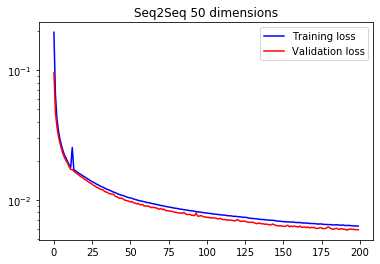

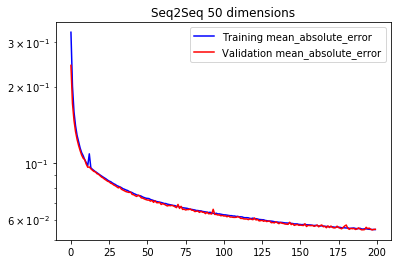

In [27]:
num_epochs = 200
m, enc, dec = seq2seq(history, future, latent_dim=30, num_features=4, 
                      num_layers_enc=3, activation_dense='elu', 
                      mn_dense=0.5, mn_rec=0.2)
m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipvalue=1.0), 
          loss=MSE, metrics=['mean_absolute_error'])
h = m.fit(x=train_data[0], y=train_data[1], batch_size=train_batch, epochs=num_epochs, 
          validation_data=vad_data)
plot_train_history(h, 'Seq2Seq 50 dimensions', metric='loss')
plot_train_history(h, 'Seq2Seq 50 dimensions', metric='mean_absolute_error')


### Inference

In [0]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_steps, start_char):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = start_char

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    decoded_seq = np.zeros(shape=(1, num_steps, 1), dtype=np.float)
    for i in np.arange(num_steps):
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        out = output_tokens[0, 0, 0]
        decoded_seq[0, i, 0] = out

        # Update the target sequence (of length 1).
        target_seq[0, 0, 0] = out

        # Update states
        states_value = [h, c]

    return decoded_seq

def decode_sequences(dataset, encoder_model, decoder_model, history, future, start_char):
    num_seq = dataset.shape[0]
    decoded_seq = np.zeros(shape=(num_seq, future))
    for idx in np.arange(num_seq):
        if (idx+1) % 500 == 0:
            print("Predicted %s sequences" %(idx+1))
        input_seq = dataset[idx, :history, :]
        input_seq = input_seq[np.newaxis, :, :]
        decoded_seq_ = decode_sequence(input_seq, encoder_model, decoder_model, 
                                       future, start_char)
        decoded_seq[idx, :] = np.squeeze(decoded_seq_)
    return decoded_seq

def mae(dataset, prediction, history, future):
    expected = dataset[:, history:history+future, -1]
    return np.mean(np.abs(expected - prediction))

def plot_results(dataset, prediction, history, future):
    plt.figure()

    # get random idx
    idx = np.random.randint(0, dataset.shape[0])

    # get intervals
    xf = dataset[idx, :history, 0]
    xl = dataset[idx, history:history+future, 0]
    
    # get sequences
    input_seq_ = dataset[idx, :history, -1]
    target_seq_ = dataset[idx, history:history+future, -1]
    decoded_seq_ = prediction[idx, :]

    plt.plot(xf, input_seq_, '-b', markersize=2, linewidth=1)
    plt.plot(xl, target_seq_, '.--b', markersize=2, linewidth=1)
    plt.plot(xl, decoded_seq_, '.--k', markersize=2, linewidth=1)

    plt.show()

In [29]:
prediction = decode_sequences(test, enc, dec, history, future, start_char)
err = mae(test, prediction, history, future)
print("MAE in test set is %.3f" %err)

Predicted 500 sequences
Predicted 1000 sequences
Predicted 1500 sequences
Predicted 2000 sequences
Predicted 2500 sequences
Predicted 3000 sequences
Predicted 3500 sequences
Predicted 4000 sequences
Predicted 4500 sequences
Predicted 5000 sequences
Predicted 5500 sequences
Predicted 6000 sequences
Predicted 6500 sequences
Predicted 7000 sequences
Predicted 7500 sequences
Predicted 8000 sequences
Predicted 8500 sequences
MAE in test set is 0.165


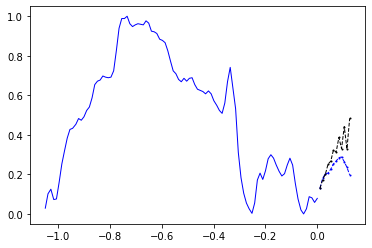

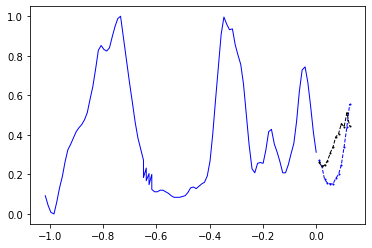

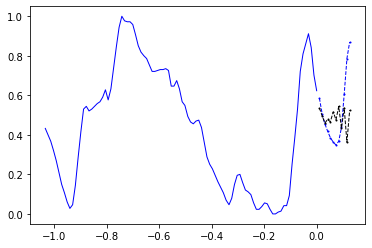

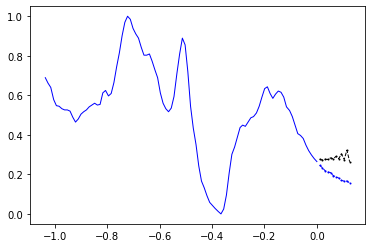

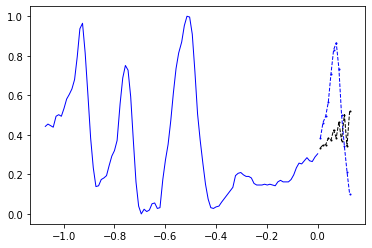

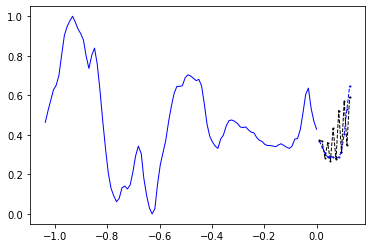

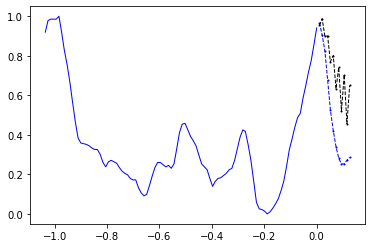

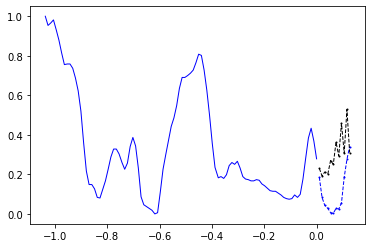

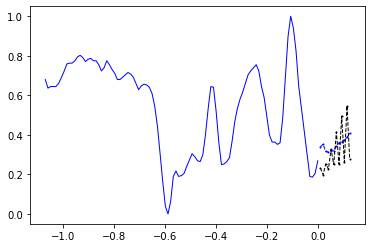

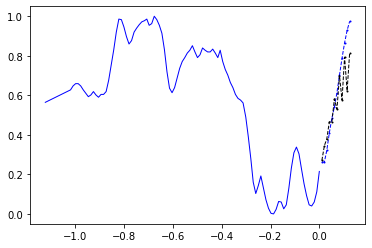

In [30]:
for _ in np.arange(10):
  plot_results(test, prediction, history, future)